# Sequential Entropy Pooling example
This notebook presents an elementary example of Entropy Pooling views on mean and volatility of S&P 500 and STOXX 50.

At the end, there is an example of how to apply Entropy Pooling in a sequential way for even better results. For more on sequential Entropy Pooling, see https://ssrn.com/abstract=3936392. For a video walkthrough of the article and its accompanied code, see https://youtu.be/hDt103zEML8.

You can watch a video walkthrough of the example and learn more about Entropy Pooling here: https://youtu.be/DK1Pv5tuLgo.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import yfinance as yf
import fortitudo.tech as ft
import matplotlib.pyplot as plt
from entropy_pooling import ep

# S&P 500 and STOXX 50 data

In [2]:
tickers = ['^GSPC', '^STOXX50E']
data = yf.download(tickers, start='2007-03-30', end='2024-02-24')['Adj Close']
data.bfill(inplace=True)
column_names = ['S&P 500', 'STOXX 50']
data.columns = column_names

[*********************100%%**********************]  2 of 2 completed


In [3]:
R_df = pd.DataFrame(
    100 * (data.iloc[1:].values / data.iloc[0:-1].values - 1),
    columns=column_names)

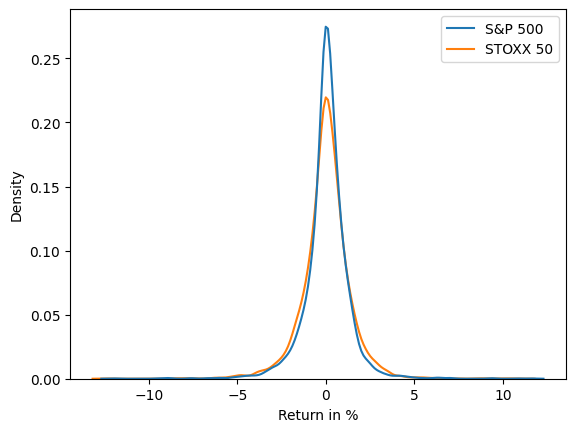

In [4]:
sns.kdeplot(R_df)
plt.xlabel('Return in %')
plt.show()

# Entropy Pooling views
We specify the view that the mean of STOXX 50 is half a standard deviation lower than the prior and that the volatility of S&P 500 is 20% higher relative to the prior value.

We first use the original Entropy Pooling suggestion and fix the posterior mean of S&P 500 to its prior value when implementing the volatility view and then compare it to the sequential refinement where the mean is allowed to change according to the STOXX 50 mean view before the S&P 500 view on volatility is implemented.

For more details on sequential Entropy Pooling, see https://ssrn.com/abstract=3936392.

# Original heuristic

In [5]:
R = R_df.values
S = R.shape[0]
p = np.ones((S, 1)) / S
means_prior = p.T @ R
vols_prior = np.sqrt(p.T @ (R - means_prior)**2)

mean_rows = R.T
vol_row = (R[:, 0] - means_prior[0, 0])[np.newaxis]**2
A = np.vstack((np.ones((1, S)), mean_rows, vol_row))
b = np.array([[1],
              [means_prior[0, 0]],
              [means_prior[0, 1] - 0.5 * vols_prior[0, 1]],
              [(1.2 * vols_prior[0, 0])**2]])

In [6]:
q = ep(p, A, b)
relative_entropy = q.T @ (np.log(q) - np.log(p))
effective_number_scenarios = np.exp(-relative_entropy)
print(f'RE = {np.round(relative_entropy[0, 0], 3)}.')
print(f'Relative ENS = {np.round(effective_number_scenarios[0, 0], 3)}.')

RE = 0.163.
Relative ENS = 0.85.


In [7]:
stats_prior = ft.simulation_moments(R_df)
display(stats_prior)

,Mean,Volatility,Skewness,Kurtosis
S&P 500,0.037364,1.265002,-0.252239,15.059437
STOXX 50,0.013323,1.398997,-0.093614,10.675691


In [8]:
ft.simulation_moments(R_df, q)

,Mean,Volatility,Skewness,Kurtosis
S&P 500,0.037364,1.518002,0.278625,14.039257
STOXX 50,-0.686176,1.811450,-1.840247,9.477816


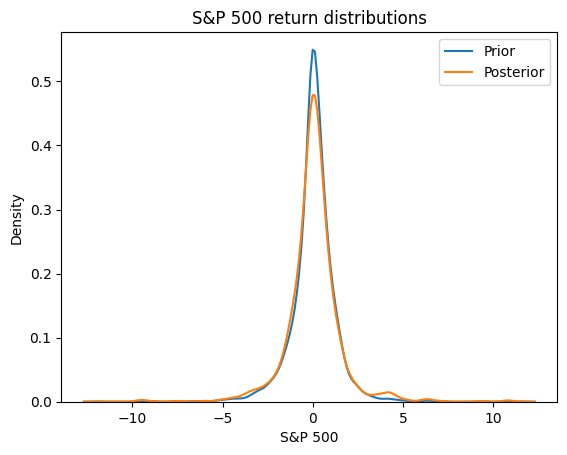

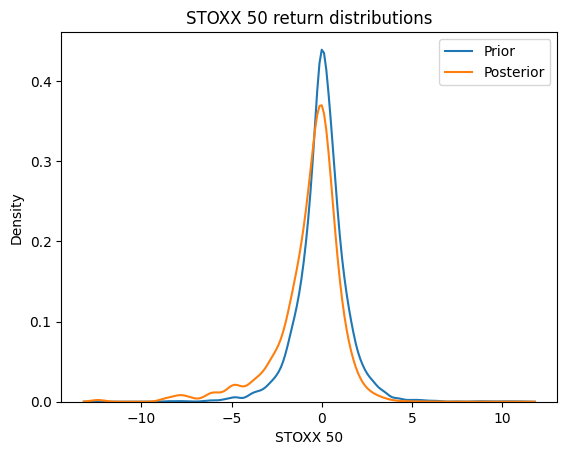

In [9]:
sns.kdeplot(x=R_df.iloc[:, 0])
sns.kdeplot(x=R_df.iloc[:, 0], weights=q[:, 0])
plt.title('S&P 500 return distributions')
plt.legend(['Prior', 'Posterior'])
plt.show()

sns.kdeplot(x=R_df.iloc[:, 1])
sns.kdeplot(x=R_df.iloc[:, 1], weights=q[:, 0])
plt.title('STOXX 50 return distributions')
plt.legend(['Prior', 'Posterior'])
plt.show()

# Sequential heuristic (H1)
See https://ssrn.com/abstract=3936392 for more information.

In [10]:
# C0 views
mean_row = R[:, 1][np.newaxis]
A0 = np.vstack((np.ones((1, S)), mean_row))
b0 = np.array([[1.], [means_prior[0, 1] - 0.5 * vols_prior[0, 1]]])
q0 = ep(p, A0, b0)

In [11]:
ft.simulation_moments(R_df, q0)

,Mean,Volatility,Skewness,Kurtosis
S&P 500,-0.363015,1.683497,-2.20139,14.289760
STOXX 50,-0.686176,1.937072,-2.40445,13.300724


In [12]:
# C1 views
means0 = q0.T @ R
vol_row0 = (R[:, 0] - means0[0, 0])[np.newaxis]**2
A1 = np.vstack((np.ones((1, S)), mean_rows, vol_row0))
b1 = np.array([[1.], [means0[0, 0]], [means0[0, 1]], [(1.2 * vols_prior[0, 0])**2]])
q1 = ep(p, A1, b1)

In [13]:
ft.simulation_moments(R_df, q1)

,Mean,Volatility,Skewness,Kurtosis
S&P 500,-0.363015,1.518002,-2.107346,13.547514
STOXX 50,-0.686176,1.832161,-2.211957,12.250794


In [14]:
relative_entropy1 = q1.T @ (np.log(q1) - np.log(p))
effective_number_scenarios1 = np.exp(-relative_entropy1)
print(f'RE = {np.round(relative_entropy1[0, 0], 3)}.')
print(f'Relative ENS = {np.round(effective_number_scenarios1[0, 0], 3)}.')

RE = 0.112.
Relative ENS = 0.894.


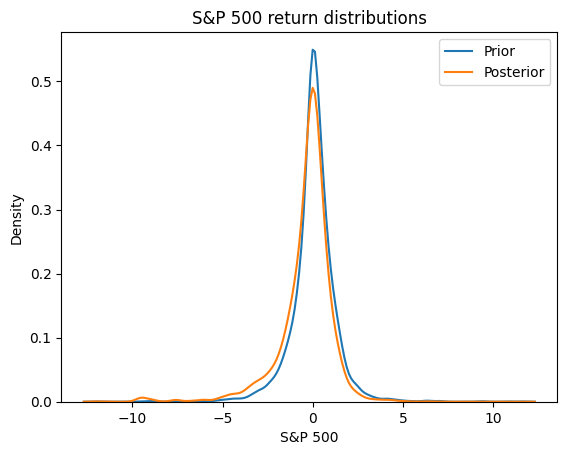

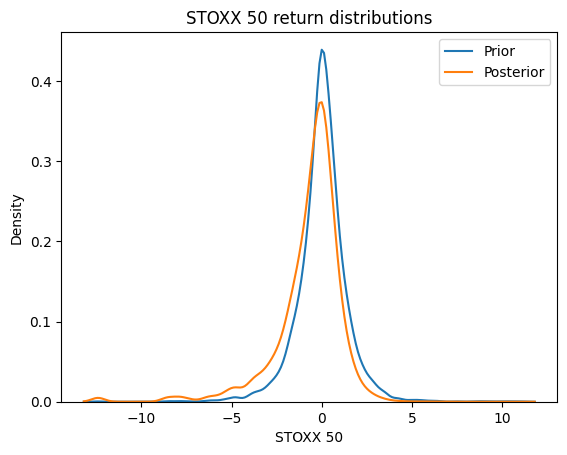

In [15]:
sns.kdeplot(x=R_df.iloc[:, 0])
sns.kdeplot(x=R_df.iloc[:, 0], weights=q1[:, 0])
plt.title('S&P 500 return distributions')
plt.legend(['Prior', 'Posterior'])
plt.show()

sns.kdeplot(x=R_df.iloc[:, 1])
sns.kdeplot(x=R_df.iloc[:, 1], weights=q1[:, 0])
plt.title('STOXX 50 return distributions')
plt.legend(['Prior', 'Posterior'])
plt.show()

# Comments
In this example, views and sequential Entropy Pooling is implemented in a "handheld" way. For practical use cases, a better interface as well as an automated implementation of sequential Entropy Pooling is recommended. If you are an institutional investor who wants to experience an elegant implementation of this, please request a demo by sending an email to demo@fortitudo.tech.

# License

In [16]:
# Copyright (c) 2021-2024, Fortitudo Technologies
# This work is licensed under BSD 3-Clause "New" or "Revised" License:
# https://github.com/fortitudo-tech/entropy-pooling/blob/main/LICENSE